In [74]:
# By Chelsea Parlett-Pelleriti
library(ggplot2)
library(glmnet)

# Introduction

Regularization is a way to adjust your *loss function* to reflect the belief that very small relationships between variables are *probably* due to weird quirks of our particular sample, and don't apply to the population as a whole. Forcing these small relationships to be smaller (Ridge) or zero (LASSO) can help our model perform better on *other* samples of data, therefore helping to combat overfitting.

LASSO specifically is used as a method of **variable selection**, because reducing a variables coefficient to zero is essentially the same thing as *removing* it from the model. While in ML we often don't care about or use p-values, the Statistician part of me needs to tell you this: *if you use LASSO to choose the variables in your model, the p-values and confidence intervals are NO LONGER VALID.* If you want to use p-values and CIs still, you need to correct for the fact that you "cherry-picked" the best variables from the model. See [this paper](https://www.pnas.org/content/112/25/7629) if you're ever going to do this. PLEASE.

## Ridge
Ridge Regression adds an extra penalty to the typical regression loss function: the L2 Norm. L2 refers to the fact that we take every coefficient, square it (i.e. take it to the 2nd power), add them together, and take the square root. You might notice that the L2 norm is also how we calculate distances, which is why the `np.linalg.norm()` function has been helpful to calculate distances!

$$ L2 = \sqrt{\sum_{i = 1}^N X_N^2}$$

## LASSO
LASSO adds a *different* extra penalty to the typical regression loss function: the L1 Norm. L1 refers to the fact that we take every coefficient, take the absolute value, and add them together. 

$$ L1 = \sum_{i = 1}^N \lvert X_N\rvert $$



## Alternative Regularization Explanation

You can also think of Ridge and LASSO as having a "budget" for how big the sum of your (squared or absolute valued) coefficients can be.

![](https://qph.fs.quoracdn.net/main-qimg-2a88e2acc009fa4de3edeb51e683ca02.webp)

This graph shows the concept of LASSO and RIDGE in a simple 2-parameter situation. The teal/blue circle (right) and square (left) represent the values for $\beta_1$ and $\beta_2$ that satisfy the "budget" for our coefficients. The dot in the middle of the red rings represents what the coefficients would be if we did not add a penalty at all. As you move from the inner to the outer red rings, the Residual Sums of Squares (RSS) goes up, meaning that our model is worse at accurately predicting data in our sample (remember that we're giving up accuracy in the *current* sample, to hopefully gain accuracy out-of-sample).

You can see that the coefficients chosen by LASSO/Ridge occur at the point of the teal/blue area that meets the red rings. This is because 1) when we penalize our model, it HAS to fit within the contraints we give it (the teal/blue area) but 2) we still want the RSS to be as small as possible (a model that's bad on ALL data sets isn't useful).

## How to choose between LASSO and Ridge?

In general: if you want to do variable selection (i.e. completely remove some variables), choose LASSO. But in the real world, people often use something called Elastic Net, which adds both LASSO (L1) *and* Ridge (L2) penalties to the loss function:

$$ ElasticNet = \alpha \sum_{i = 1}^N \lvert X_N\rvert + (1-\alpha)\sqrt{\sum_{i = 1}^N X_N^2} $$

# Comparing Coefficients of Regression, LASSO, and Ridge

The function `compare()` simulates a large dataset with 17 variables. 7 of those variables (the vowels, AEIOUYW) do have real relationships with the outcome, `X`. You can see the true coefficients in the part of the code that looks like this:

```
 # coefficients
    a = 8.23
    e = 3.48
    i = 2.97
    o = 5.12
    u = 7.83
    y = 12.34
    w = 1.38
    
```

10 of the variables (the consonants, BCDFGHJKLMN) do not have *any* relationship with `X` (i.e. their true coefficient is 0).


`compare()` then runs regular Regression (no penalty), Ridge Regression (L2 penalty) and LASSO (L1 penalty). 

In [75]:
# Simulation Settings
n = 1000 #number of samples per model
nsims = 1000 # number of simulations
lambda = 0.05

In [76]:
    # simulate data and run linear, ridge, and lasso models
    compare <- function(n = 1000, lambda = 0.05){

    # CREATE DATA
    # ---Real Variables
    A <- rnorm(n,0,1)
    E <- rnorm(n,0,1)
    I <- rnorm(n,0,1)
    O <- rnorm(n,0,1)
    U <- rnorm(n,0,1)
    Y <- rnorm(n,0,1)
    W <- rnorm(n,0,1)

    # ---Unrelated Variables
    B <- rnorm(n,0,1)
    C <- rnorm(n,0,1)
    D <- rnorm(n,0,1)
    G <- rnorm(n,0,1)
    H <- rnorm(n,0,1)
    J <- rnorm(n,0,1)
    K <- rnorm(n,0,1)
    L <- rnorm(n,0,1)
    M <- rnorm(n,0,1)
    N <- rnorm(n,0,1)


    # ---generate outcome + random variation
    # coefficients
    a = 8.23
    e = 3.48
    i = 2.97
    o = 5.12
    u = 7.83
    y = 12.34
    w = 1.38
        
    X <- 100 + A*a + E*e + 
    I*i + O*o + U*u +
    Y*y + W*w + rnorm(n,0,15)

    X <- scale(X) # z-score

    # ---Data Frame
    df <- data.frame(A,E,I,O,U,B,C,D,G,H,J,K,L,M,N,Y,W,X)

    # MODELING
    # ---linear regression
    lr <- lm(X ~ A + B + C + D + E + G + H + I + J + K + L + M + N + O + U + Y + W,
           data = df)
    lr.co <- coef(lr)

    # ---lasso
    lasso <- glmnet(as.matrix(df[,1:17]), df[, 18], alpha = 1, lambda = lambda,
                  thresh = 1e-07, standardize = FALSE,
                  intercept=TRUE, standardize.response = FALSE)
    lasso.co <- coef(lasso)

    # ---ridge
    ridge <- glmnet(as.matrix(df[,1:17]), df[, 18], alpha = 0, lambda = lambda,
                  thresh = 1e-07, standardize = FALSE,
                  intercept=TRUE, standardize.response = FALSE)
    ridge.co <- coef(ridge)

    # STORE COEFFICIENTS
    # ---fill in lasso coefs because R doesn't return entries for ones that are 0
    conames <- c(names(lr.co), lasso.co@Dimnames[[1]],ridge.co@Dimnames[[1]])
    lasso.coefs <- rep(0,18)
    lasso.coefs[lasso.co@i+1] <- lasso.co@x

    # ---combine all simulated coefs
    coefs <- c(as.numeric(lr.co),lasso.coefs, ridge.co@x)

    # ---label models for df
    model <- c(rep("linear", 18), rep("lasso", 18), rep("ridge", 18))

    # ---convert coefs back to normal scale
    coefs2 <- coefs*attr(X, 'scaled:scale') 

    return(data.frame(conames = conames,coefs = coefs2, model = model))
    }

In [77]:
# run simulation
sim <- lapply(1:nsims,function(x) compare(n = n, lambda = lambda))
sim <- do.call(rbind,sim)

sim$conames <- factor(sim$conames, levels = c("A", "E", "I", "O", "U", "Y", "W",
                                              "B","C","D","G","H","J","K","L", "M","N"))

sim$vowel <- ifelse(sim$conames %in% c("A","E","I","O","U","Y", "W"), 1,0)

The plots below look at the range of values the coefficients for each effect took on over the `nsim` simulations. 

By default, coefficients represented by vowels (A, E, I ,O , U, and sometimes Y and W...does anyone else remember that rhyme?) DO have true population effects that are > 0. Consonants have no effect in the population.

Interestingly, we can see that in effects that are real (vowels), we see that lasso has lower estimates in general, ridge has slightly higher estimates than lasso, and linear regression has the highest coefficients. I think this shows clearly the some of the differences between Ridge and LASSO.

In coefficients that have no real effect, LASSO almost ALWAYS has them at exactly 0. Whereas linear and Ridge regression have more variation, allowing the coefficients to be small, but non-zero.

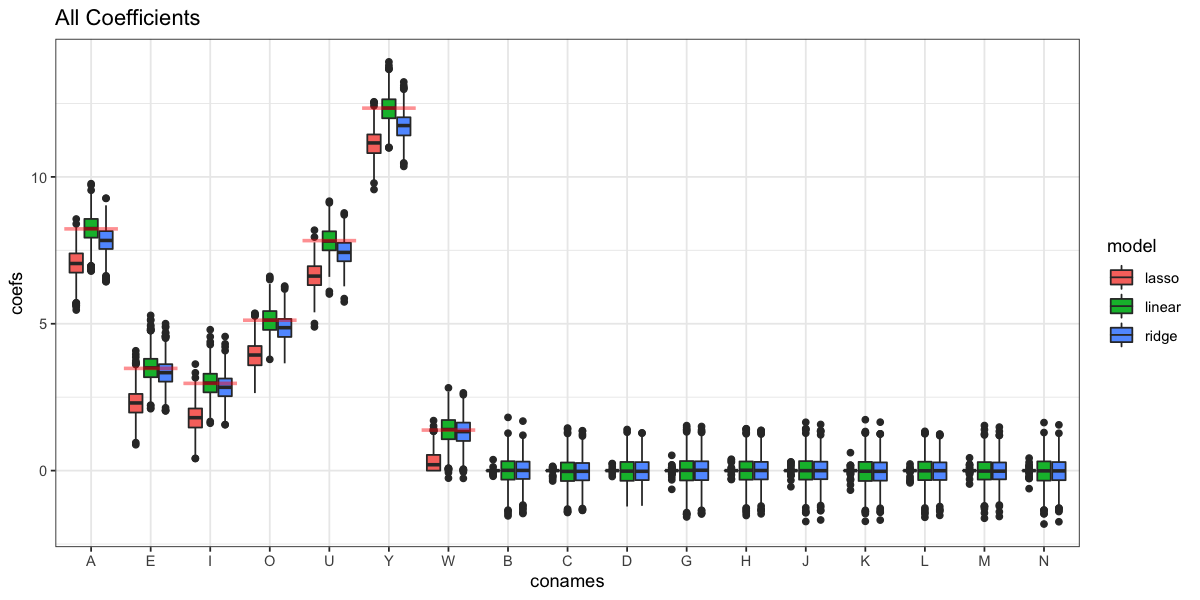

In [78]:
# All Coefficients

coefs_df <- data.frame(coefs = c(8.23,3.48,2.97,5.12,7.83,12.34,1.38),
                       conames = c("A", "E", "I", "O", "U", "Y", "W"))

options(repr.plot.width=10, repr.plot.height=5) # make the plot wide

ggplot(sim[sim$conames %in% c("A", "E", "I", "O", "U", "Y", "W",
                              "B","C","D","G","H","J","K","L", "M","N"),],
                                           aes(x = conames,
                                           y = coefs,
                                           fill = model)) +
  geom_boxplot() +
  ggtitle("All Coefficients") +
  geom_errorbar(data = coefs_df,
                mapping = aes(x = conames, y = coefs, ymin = coefs, ymax = coefs),
                inherit.aes = FALSE,
                color = "red",
                alpha = 0.25,
                size = 1) + theme_bw()

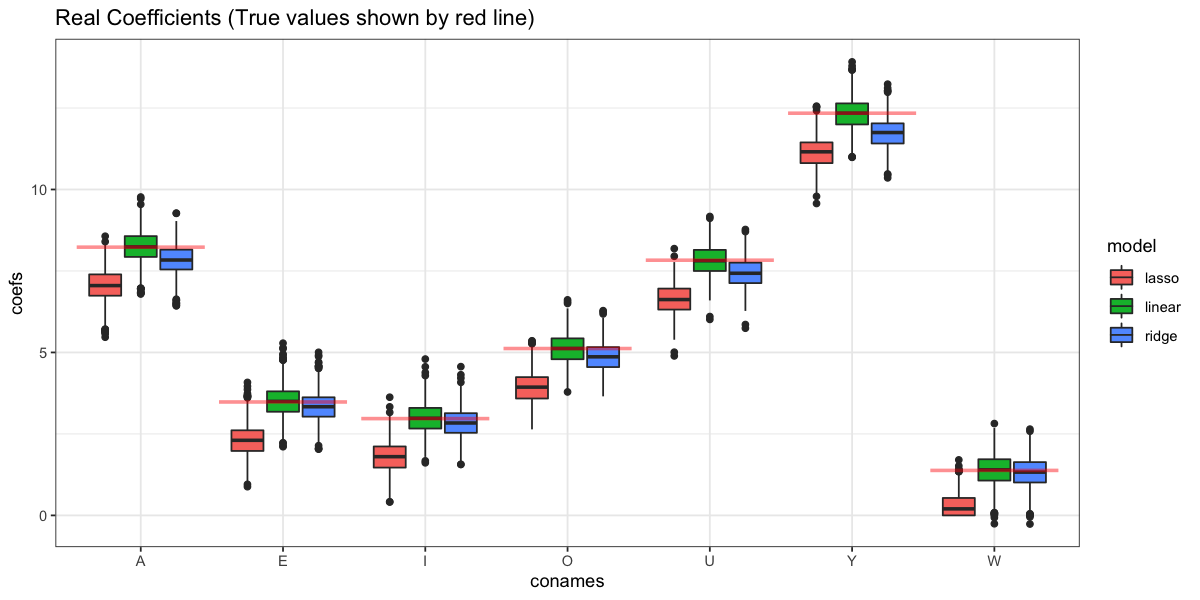

In [79]:
#just vowels (actual effects)
ggplot(sim[sim$conames %in% c("A", "E", "I", "O", "U", "Y", "W"),], aes(x = conames,
                                                                               y = coefs,
                                                                               fill = model)) +
  geom_boxplot() + ggtitle("Real Coefficients (True values shown by red line)") +
  geom_errorbar(data = coefs_df,
                mapping = aes(x = conames, y = coefs, ymin = coefs, ymax = coefs),
                inherit.aes = FALSE,
                color = "red",
                alpha = 0.25,
                size = 1) + theme_bw()


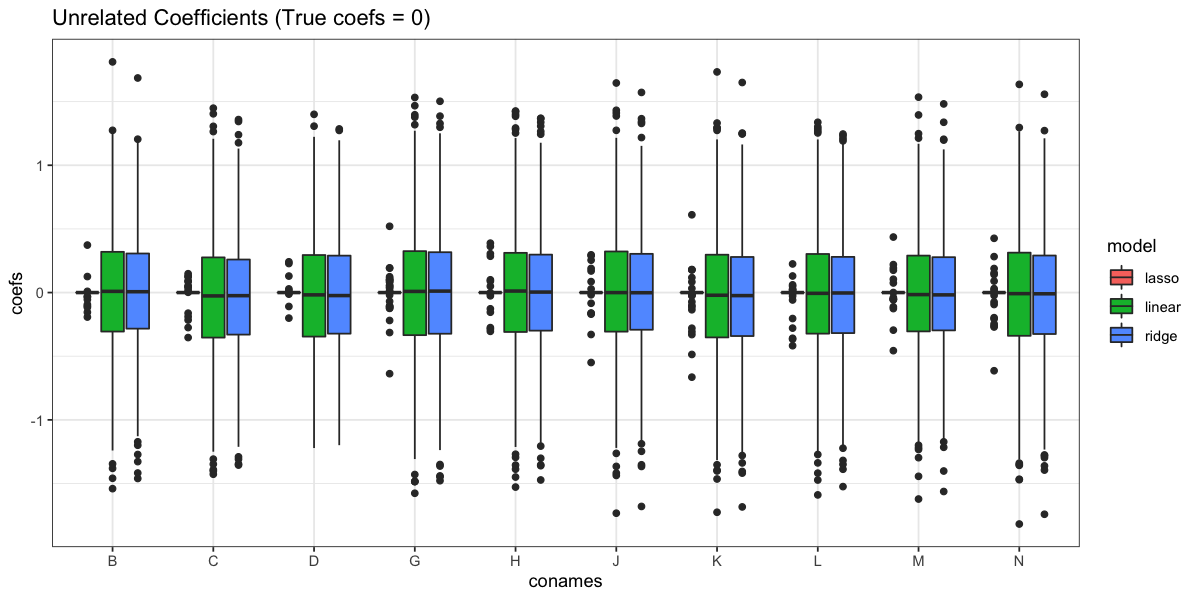

In [80]:
#just consonants (no real effects)

ggplot(sim[sim$conames %in% c("B","C","D","G","H","J","K","L", "M","N"),], aes(x = conames,
                                                                               y = coefs,
                                                                               fill = model)) +
  geom_boxplot() + ggtitle("Unrelated Coefficients (True coefs = 0)") + theme_bw()

### *Question*

Compare the ranges (using the boxplots generated above) of coefficients when using Linear Regression (unpenalized), LASSO (L1 penalty), and Ridge (L2 penalty). What patterns do you see in the coefficients that *do* have relationships with X (vowels)? What patterns do you see in the coefficients that *do not* have relationships with X (consonants)?

<img src="https://drive.google.com/uc?export=view&id=1gquRjmDWGDbuNSqcgVJ-py11VoxrfEJf" width = 200px />

### *Question*

What do you think will happen if you increase `alpha`, which controls how much we penalize large coefficients? Try it out below:

<img src="https://drive.google.com/uc?export=view&id=1gquRjmDWGDbuNSqcgVJ-py11VoxrfEJf" width = 200px />

### *Question*

What do you think will happen if you decrease `alpha`, which controls how much we penalize large coefficients? Try it out below (you can set `alpha` to be very small, but for computational reasons, don't set it to be exactly zero):

<img src="https://drive.google.com/uc?export=view&id=1gquRjmDWGDbuNSqcgVJ-py11VoxrfEJf" width = 200px />
